In [21]:
import os
import pandas
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
import graphviz
from utils import *

# Set the font to Roboto
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Roboto']

In [60]:
def readconfig(conf):
    out = dict()
    with open(conf, 'r') as stream:
        for line in stream:
            line = line.strip()
            if line and not line.startswith('#'):
                option, value = line.strip().split('=', 1)
                option = option[7:]
                out[option] = value
    return out


def build_df(kallpath, reppath, cspath):
    kall = Path(kallpath).read_text().splitlines()
    repro = list(map(lambda x: {'True': 1, 'False': 0}[x], Path(reppath).read_text().splitlines()))
    table = dict()
    for opt in kall:
        table[opt] = [0 for _ in range(len(repro))]
    table["REPRODUCIBLE"] = repro
    for i, conf in enumerate(sorted(os.listdir(cspath))):
        for k, v in readconfig(os.path.join(cspath, conf)).items():
            table[k][i] = v
    return pandas.DataFrame.from_dict(table)


def filterdf(df):
    non_tristate = df.loc[:, ~(df.isin(['y', 'm'])).any()]\
               .drop(columns=["REPRODUCIBLE"]).columns
    df = df.drop(columns=non_tristate)
    encoding_map = {
        'y': 1,
        'm': 2,
    }
    df = df.replace(encoding_map)
    constant_columns = df.columns[df.nunique() == 1]
    df = df.drop(constant_columns, axis=1)
    return df


def dt(df, save=""):
    # Separate the target variable and features
    X = df.drop(columns=["REPRODUCIBLE"])
    y = df["REPRODUCIBLE"]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    print("Train: ", X_train.shape, "Test", X_test.shape)
    
    # Initialize the DecisionTreeClassifier
    clf = DecisionTreeClassifier()
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    
    
    ft_names = X_train.columns.tolist()
    
    # Export the decision tree to DOT format
    dot_data = export_graphviz(clf, out_file=None, 
                               feature_names=ft_names, 
                               class_names=['Unreproducible', 'Reproducible'], 
                               filled=True, rounded=True, 
                               special_characters=True)
    
    # Render and save the visualization using graphviz
    graph = graphviz.Source(dot_data)
    if save:
        graph.render(save, format="png")
    display(graph)

def mk_evolution(df):
    # Separate the target variable and features
    X = df.drop(columns=["REPRODUCIBLE"])
    y = df["REPRODUCIBLE"]

    # Range of test sizes to explore and number of repetitions
    test_sizes = np.arange(0.05, 1.0, 0.05)
    n_repetitions = 10

    # Dictionary to store accuracies for each test size
    accuracies = {test_size: [] for test_size in test_sizes}


    # Initialize dictionaries to store precision and recall for each test size
    precisions = {test_size: [] for test_size in test_sizes}
    recalls = {test_size: [] for test_size in test_sizes}

    # Loop over different test sizes and repeat training n times
    for test_size in test_sizes:
        for _ in range(n_repetitions):
            # Split the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=None)
            
            # Initialize and train the classifier
            clf = DecisionTreeClassifier()
            clf.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy, precision, and recall
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            # Append the metrics to their respective lists
            accuracies[test_size].append(accuracy)
            precisions[test_size].append(precision)
            recalls[test_size].append(recall)

    # Calculate mean and standard deviation of precision and recall
    mean_precisions = [np.mean(precisions[test_size]) for test_size in test_sizes]
    std_precisions = [np.std(precisions[test_size]) for test_size in test_sizes]
    mean_recalls = [np.mean(recalls[test_size]) for test_size in test_sizes]
    std_recalls = [np.std(recalls[test_size]) for test_size in test_sizes]

    # Calculate mean and standard deviation of accuracies
    mean_accuracies = [np.mean(accuracies[test_size]) for test_size in test_sizes]
    std_accuracies = [np.std(accuracies[test_size]) for test_size in test_sizes]

    # Total number of samples in the dataset
    total_samples = len(df)

    # Convert test sizes to training sizes
    training_sizes = 1 - np.array(list(test_sizes))

    # Convert training sizes (percentage) to absolute number of training samples
    training_samples = [int(size * total_samples) for size in training_sizes]

    # Plotting accuracy, precision, and recall with shaded standard deviation
    plt.figure(figsize=(12, 8))

    # Plot mean accuracy, precision, and recall
    plt.plot(training_samples, mean_accuracies, '-o', label='Mean Accuracy')

    # Shade the standard deviation for each metric
    plt.fill_between(training_samples, 
                    np.array(mean_accuracies) - np.array(std_accuracies), 
                    np.array(mean_accuracies) + np.array(std_accuracies), 
                    alpha=0.2)

    plt.title('Accuracy vs Number of configurations in the training set')
    plt.xlabel('Number of configurations')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.savefig("accuracy_vs_number_of_configurations.png")
    plt.show()

    # Plotting accuracy, precision, and recall with shaded standard deviation
    plt.figure(figsize=(12, 8))


    plt.plot(training_samples, mean_precisions, '-o', label='Mean Precision')
    plt.plot(training_samples, mean_recalls, '-o', label='Mean Recall')

    # Shade the standard deviation for each metric
    plt.fill_between(training_samples, 
                    np.array(mean_precisions) - np.array(std_precisions), 
                    np.array(mean_precisions) + np.array(std_precisions), 
                    alpha=0.2)
    plt.fill_between(training_samples, 
                    np.array(mean_recalls) - np.array(std_recalls), 
                    np.array(mean_recalls) + np.array(std_recalls), 
                    alpha=0.2)

    plt.title('Precision/Recall vs Number of configurations in the training set')
    plt.xlabel('Number of configurations')
    plt.ylabel('Precision/recall')
    plt.legend(loc='lower right')

    plt.savefig("precision_recall_vs_number_of_configurations.png")
    plt.show()

# RQ1 - To what extent do configurations lead to non-reproducible builds?

In [3]:
rq1df = pandas.read_csv("results/reproducibility.csv")\
                .apply(lambda x: pandas.Series(x).value_counts())\
                .fillna(0).astype(int)\
                .rename(index={False: "unreproducible",
                               True: "reproducible"})

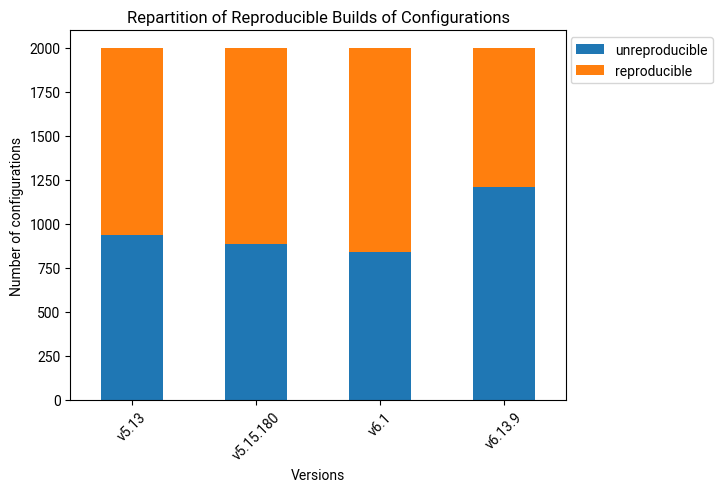

In [42]:
rq1df.T.plot(kind="bar", stacked=True)
plt.xlabel("Versions")
plt.xticks(rotation=45)
plt.ylabel("Number of configurations")
plt.title("Repartition of Reproducible Builds of Configurations")
plt.legend(loc="upper right", bbox_to_anchor=(1.31, 1),)

In [46]:
rq1df_percentage = rq1df.divide(rq1df.sum(axis=0), axis=1) * 100

Text(0.5, 1.0, 'Percentage per build status across versions')

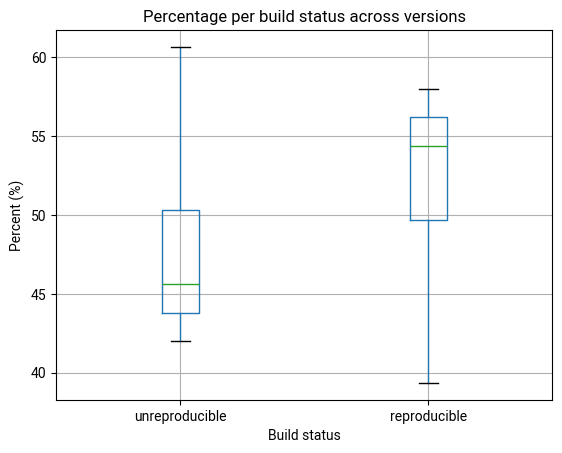

In [55]:
rq1df_percentage.T.boxplot(whis=[0, 100])
plt.xlabel("Build status")
plt.ylabel("Percent (%)")
plt.title("Percentage per build status across versions")

# RQ2 - Can we identify configuration options that cause non-reproducible builds?

## Linux v5.13

In [70]:
rq2v513df = filterdf(build_df("configs/kall-v.5.13", "results/rb-v5.13", "configs/5.13/"))

/tmp/ipykernel_1251/3440700811.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(encoding_map)


In [73]:
rq2v513df

,104_QUAD_8,60XX_WDT,6LOWPAN,6LOWPAN_DEBUGFS,6LOWPAN_GHC_EXT_HDR_DEST,6LOWPAN_GHC_EXT_HDR_FRAG,6LOWPAN_GHC_EXT_HDR_HOP,6LOWPAN_GHC_EXT_HDR_ROUTE,6LOWPAN_GHC_ICMPV6,6LOWPAN_GHC_UDP,...,ZRAM_WRITEBACK,ZSMALLOC,ZSMALLOC_STAT,ZSTD_COMPRESS,ZSTD_DECOMPRESS,ZSWAP,ZSWAP_COMPRESSOR_DEFAULT_LZO,ZSWAP_DEFAULT_ON,ZSWAP_ZPOOL_DEFAULT_ZBUD,REPRODUCIBLE
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1997,0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,1
1998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,1,0,0,0,0,0


### Decision Tree

Train:  (1200, 12168) Test (800, 12168)
Accuracy:  0.9975


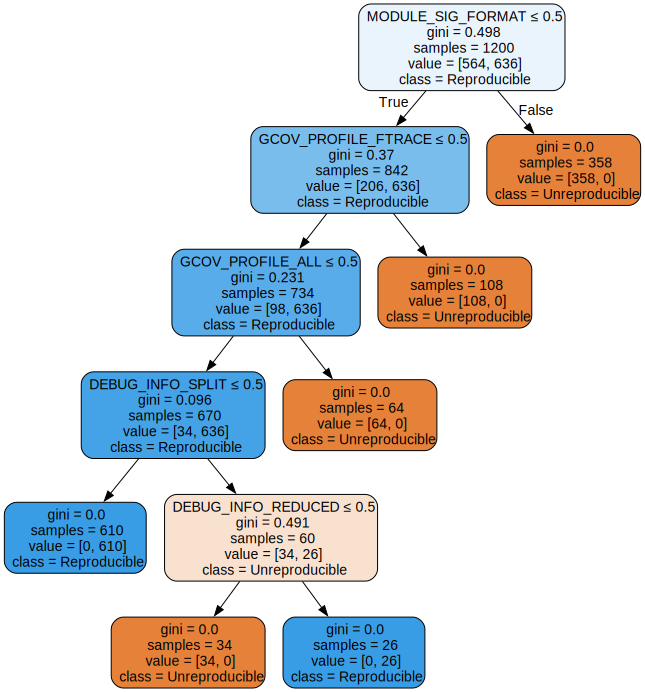

In [75]:
dt(rq2v513df)

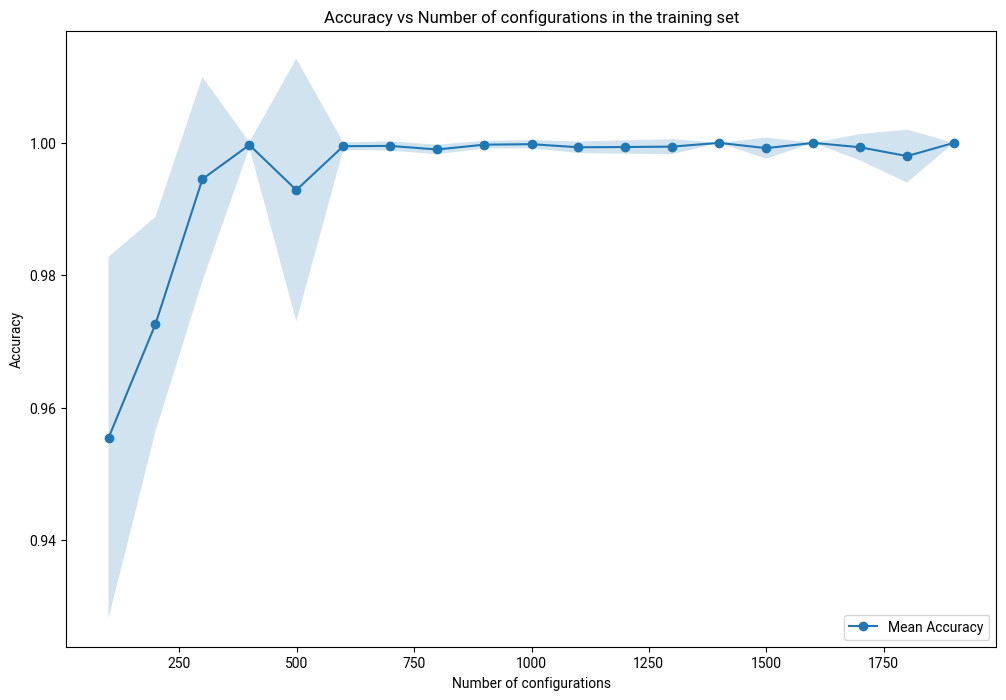

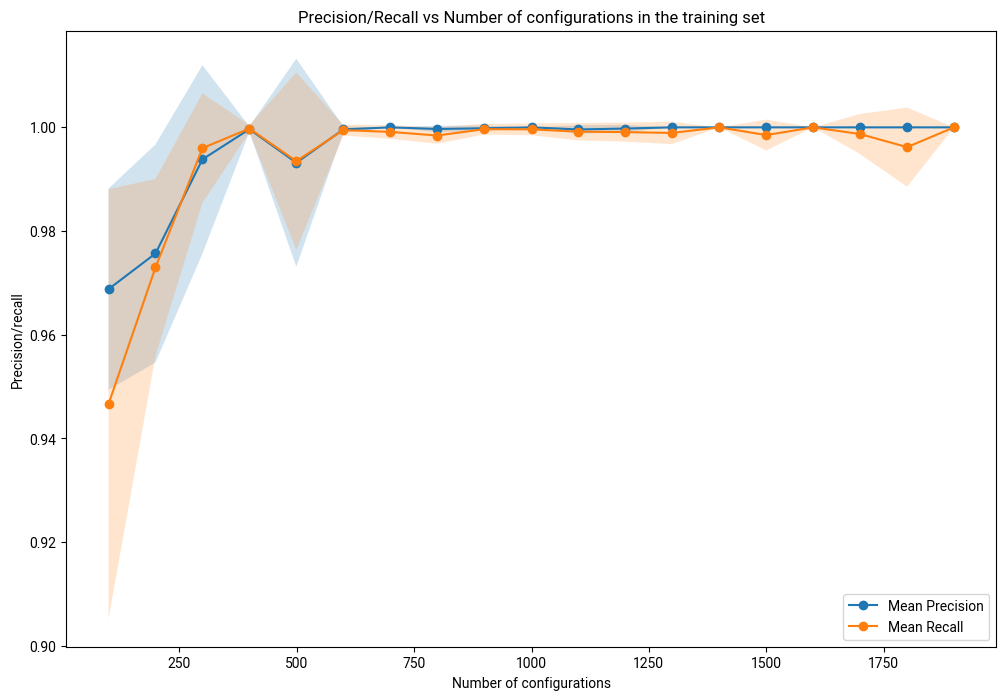

In [76]:
mk_evolution(rq2v513df)

### Queries

In [74]:
rq2v513df.query("REPRODUCIBLE == False")

,104_QUAD_8,60XX_WDT,6LOWPAN,6LOWPAN_DEBUGFS,6LOWPAN_GHC_EXT_HDR_DEST,6LOWPAN_GHC_EXT_HDR_FRAG,6LOWPAN_GHC_EXT_HDR_HOP,6LOWPAN_GHC_EXT_HDR_ROUTE,6LOWPAN_GHC_ICMPV6,6LOWPAN_GHC_UDP,...,ZRAM_WRITEBACK,ZSMALLOC,ZSMALLOC_STAT,ZSTD_COMPRESS,ZSTD_DECOMPRESS,ZSWAP,ZSWAP_COMPRESSOR_DEFAULT_LZO,ZSWAP_DEFAULT_ON,ZSWAP_ZPOOL_DEFAULT_ZBUD,REPRODUCIBLE
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,2,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
1995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,1,0,0,0,0,0


## Linux v5.15.180

In [61]:
rq2v515180df = filterdf(build_df("configs/kall-v.5.15.180", "results/rb-v5.15.180", "configs/5.15.180/"))

/tmp/ipykernel_10542/3440700811.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(encoding_map)


In [62]:
rq2v515180df

,104_QUAD_8,60XX_WDT,6LOWPAN,6LOWPAN_DEBUGFS,6LOWPAN_GHC_EXT_HDR_DEST,6LOWPAN_GHC_EXT_HDR_FRAG,6LOWPAN_GHC_EXT_HDR_HOP,6LOWPAN_GHC_EXT_HDR_ROUTE,6LOWPAN_GHC_ICMPV6,6LOWPAN_GHC_UDP,...,ZRAM_WRITEBACK,ZSMALLOC,ZSMALLOC_STAT,ZSTD_COMPRESS,ZSTD_DECOMPRESS,ZSWAP,ZSWAP_COMPRESSOR_DEFAULT_LZO,ZSWAP_DEFAULT_ON,ZSWAP_ZPOOL_DEFAULT_ZBUD,REPRODUCIBLE
0,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,0,2,0,0,0,0,0,0,0,0,...,0,2,0,2,2,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,1
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,1
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
1998,0,0,2,1,2,2,2,0,0,0,...,0,1,0,1,1,0,0,0,0,0


### Decision Tree

Train:  (1200, 12348) Test (800, 12348)
Accuracy:  1.0


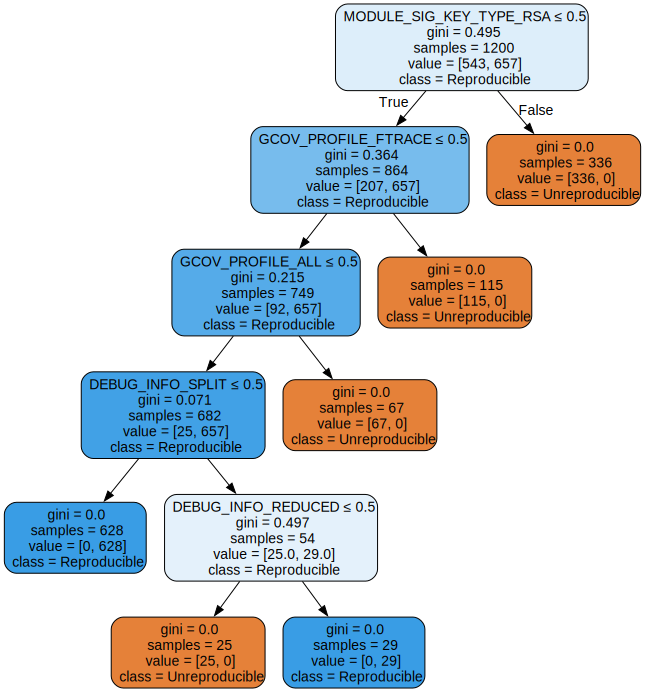

In [63]:
dt(rq2v515180df)

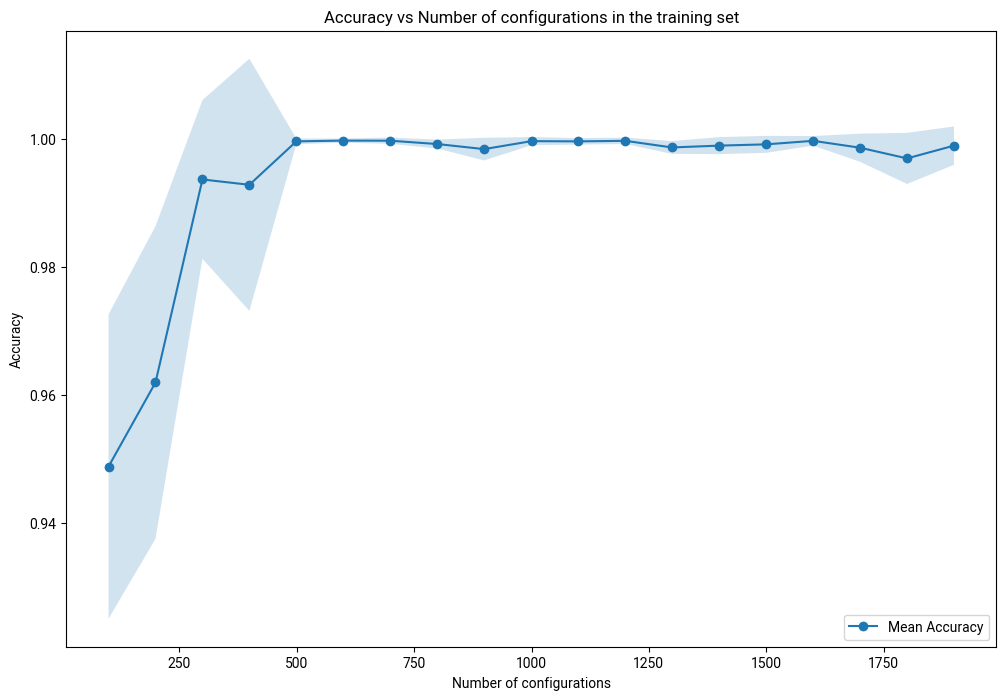

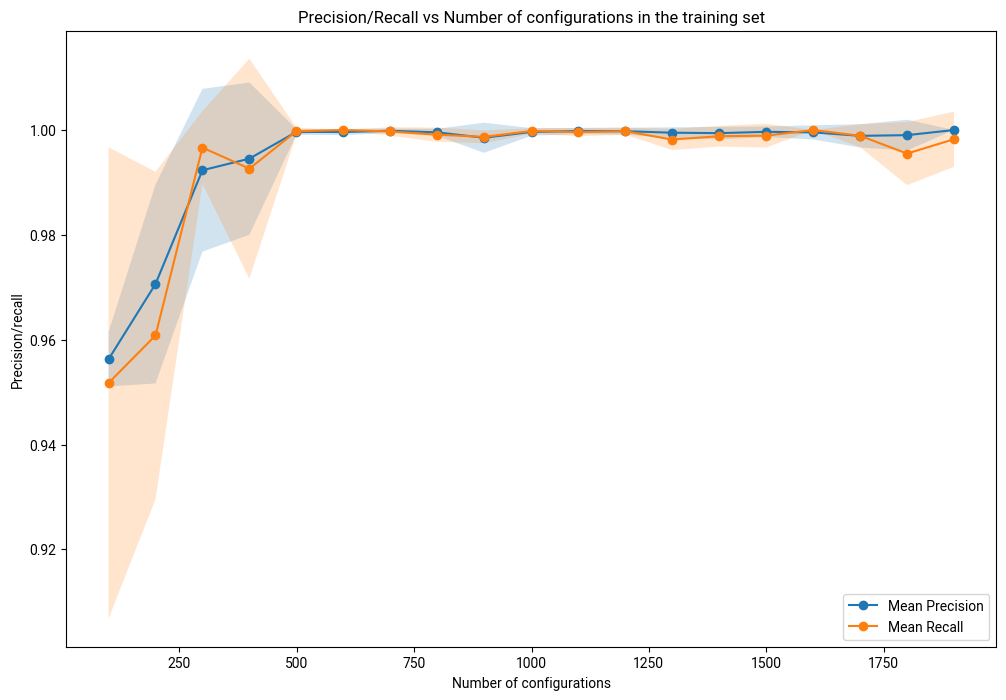

In [64]:
mk_evolution(rq2v515180df)

## Linux v6.1

In [65]:
rq2v61df = filterdf(build_df("configs/kall-v.6.1", "results/rb-v6.1", "configs/6.1/"))

/tmp/ipykernel_10542/3440700811.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(encoding_map)


In [66]:
rq2v61df

,104_QUAD_8,60XX_WDT,6LOWPAN,6LOWPAN_DEBUGFS,6LOWPAN_GHC_EXT_HDR_DEST,6LOWPAN_GHC_EXT_HDR_FRAG,6LOWPAN_GHC_EXT_HDR_HOP,6LOWPAN_GHC_EXT_HDR_ROUTE,6LOWPAN_GHC_ICMPV6,6LOWPAN_GHC_UDP,...,ZSMALLOC,ZSMALLOC_STAT,ZSTD_COMMON,ZSTD_COMPRESS,ZSTD_DECOMPRESS,ZSWAP,ZSWAP_COMPRESSOR_DEFAULT_LZO,ZSWAP_DEFAULT_ON,ZSWAP_ZPOOL_DEFAULT_ZBUD,REPRODUCIBLE
0,2,0,0,0,0,0,0,0,0,0,...,0,0,1,2,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0,1,0
3,2,0,2,1,2,2,2,0,2,2,...,0,0,2,2,2,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
1998,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


### Decision Tree

Train:  (1200, 13161) Test (800, 13161)
Accuracy:  1.0


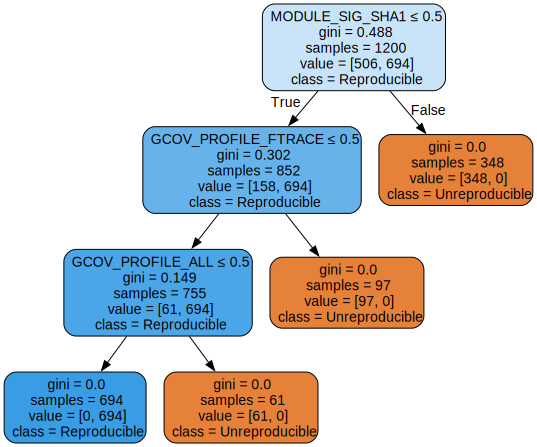

In [67]:
dt(rq2v61df)

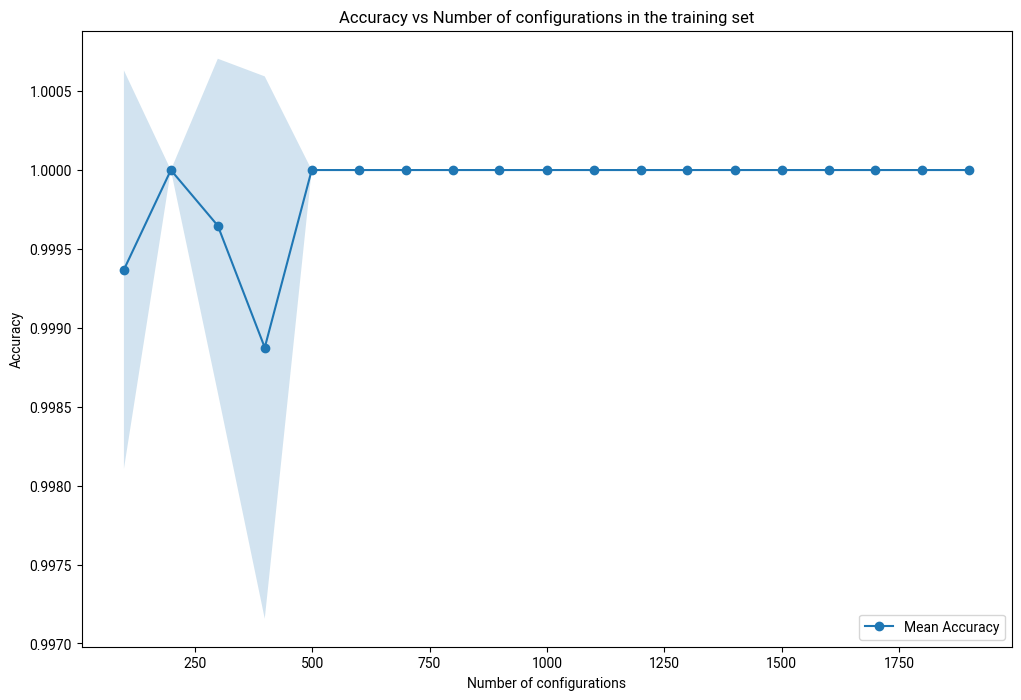

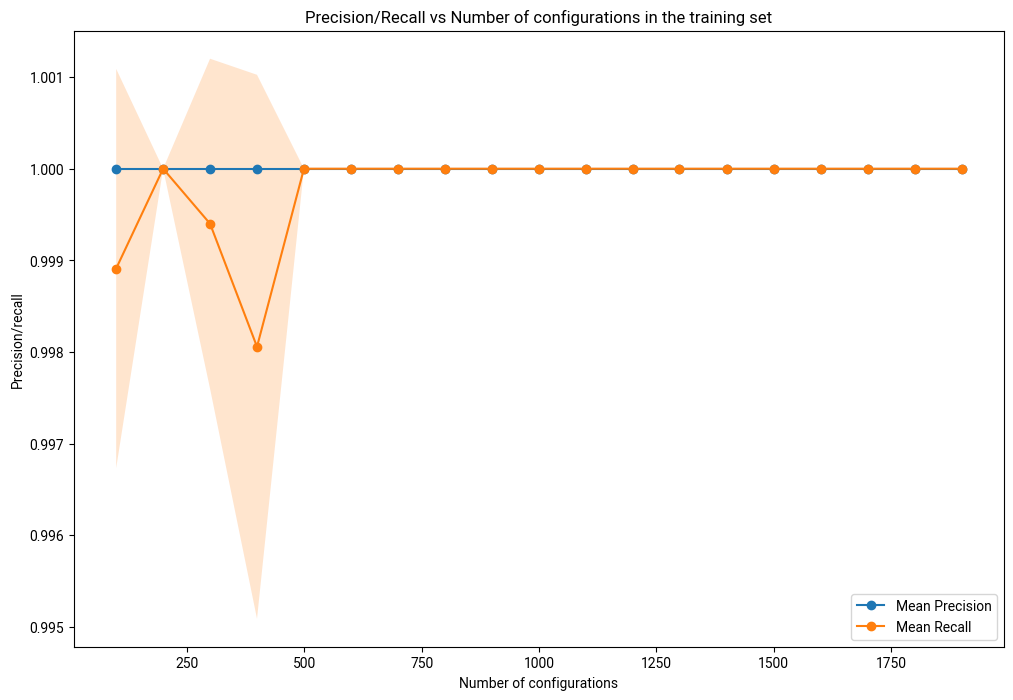

In [68]:
mk_evolution(rq2v61df)

## Linux v6.13.9

In [69]:
rq2v6139df = filterdf(build_df("configs/kall-v.6.13.9", "results/rb-v6.13.9", "configs/6.13.9/"))

/tmp/ipykernel_10542/3440700811.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(encoding_map)


In [70]:
rq2v6139df

,104_QUAD_8,60XX_WDT,6LOWPAN,6LOWPAN_DEBUGFS,6LOWPAN_GHC_EXT_HDR_DEST,6LOWPAN_GHC_EXT_HDR_FRAG,6LOWPAN_GHC_EXT_HDR_HOP,6LOWPAN_GHC_EXT_HDR_ROUTE,6LOWPAN_GHC_ICMPV6,6LOWPAN_GHC_UDP,...,ZSWAP_COMPRESSOR_DEFAULT_LZ4,ZSWAP_COMPRESSOR_DEFAULT_LZ4HC,ZSWAP_COMPRESSOR_DEFAULT_LZO,ZSWAP_COMPRESSOR_DEFAULT_ZSTD,ZSWAP_DEFAULT_ON,ZSWAP_SHRINKER_DEFAULT_ON,ZSWAP_ZPOOL_DEFAULT_Z3FOLD_DEPRECATED,ZSWAP_ZPOOL_DEFAULT_ZBUD,ZSWAP_ZPOOL_DEFAULT_ZSMALLOC,REPRODUCIBLE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,2,1,0,0,2,0,2,2,...,0,0,0,0,0,0,0,0,0,0
1998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Decision Tree

Train:  (1200, 14701) Test (800, 14701)
Accuracy:  0.97625


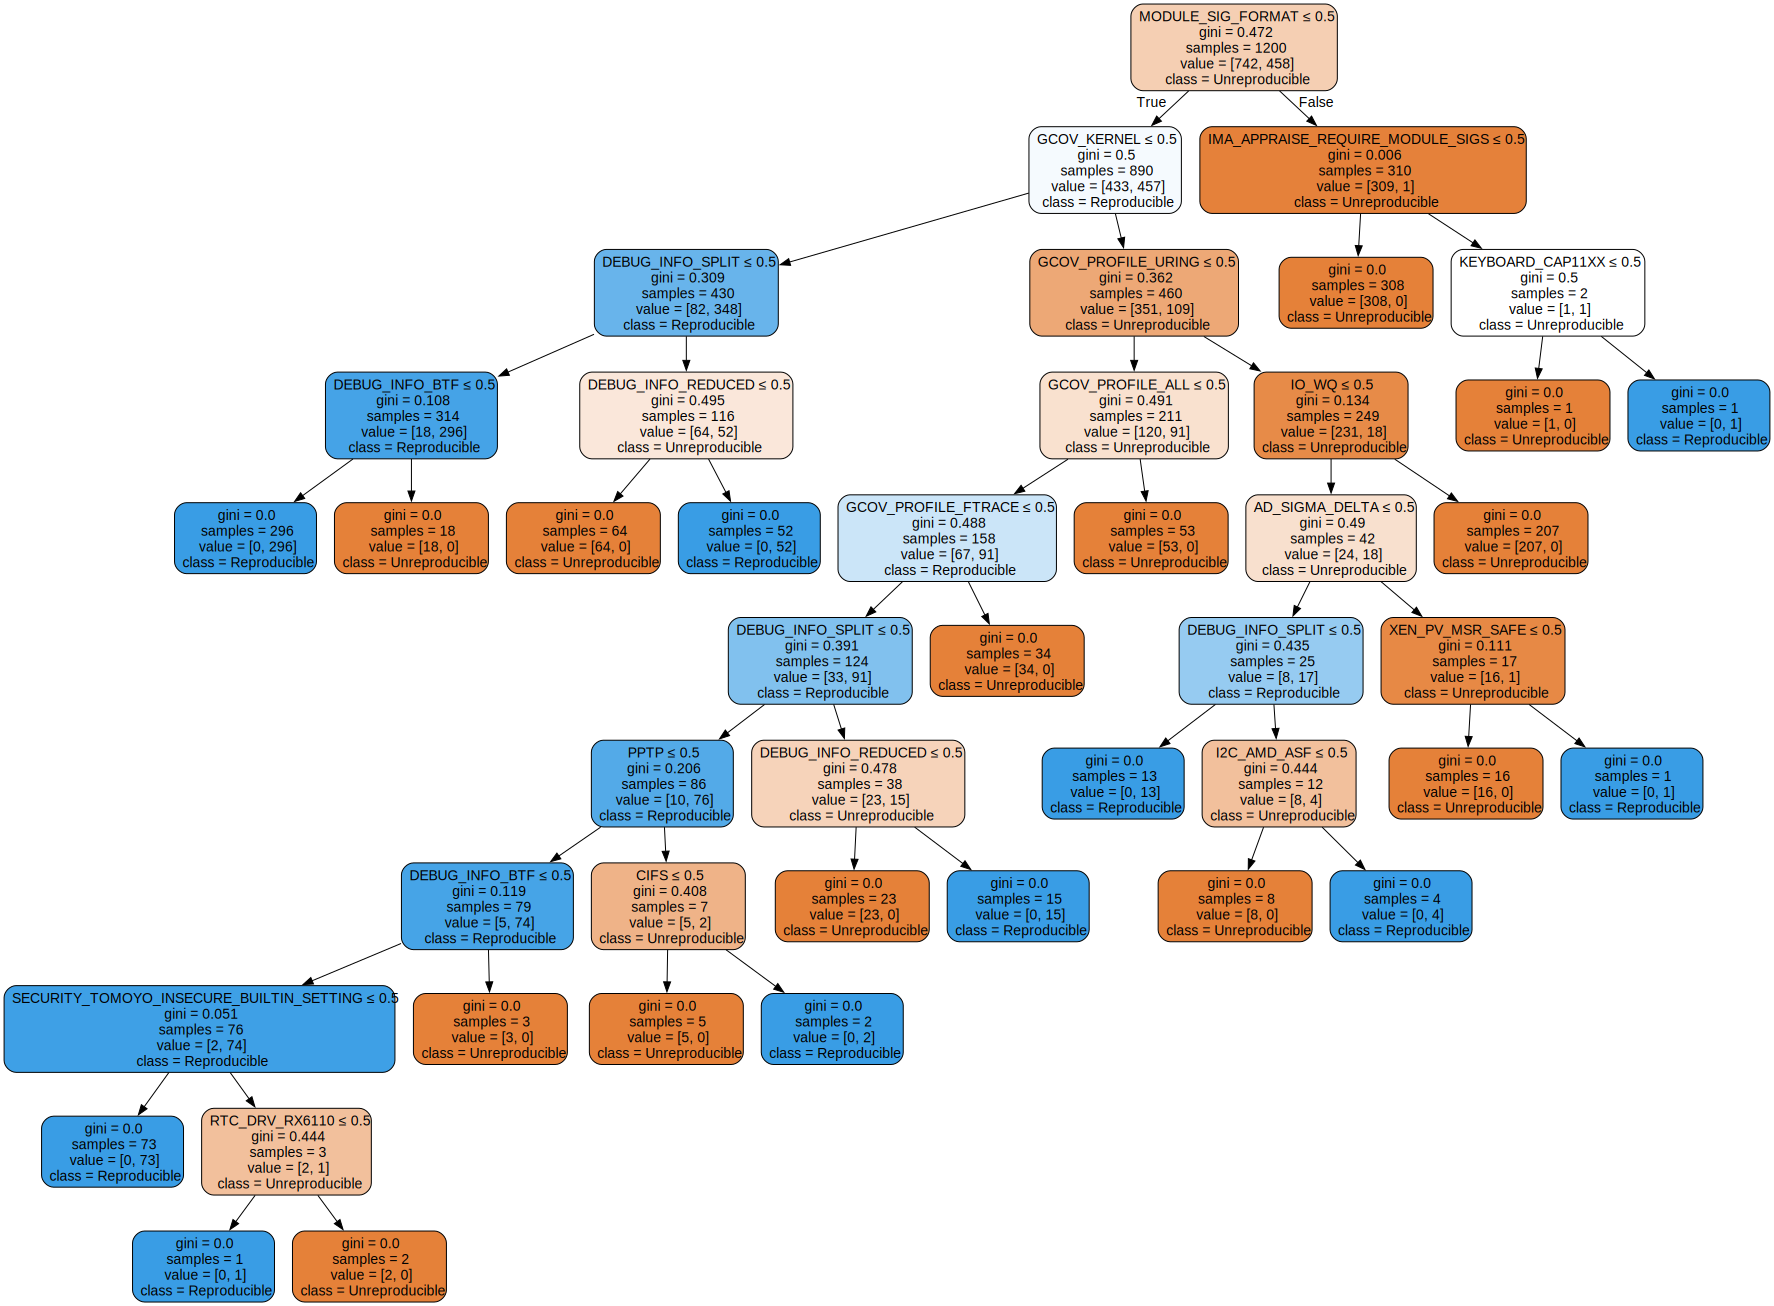

In [71]:
dt(rq2v6139df)

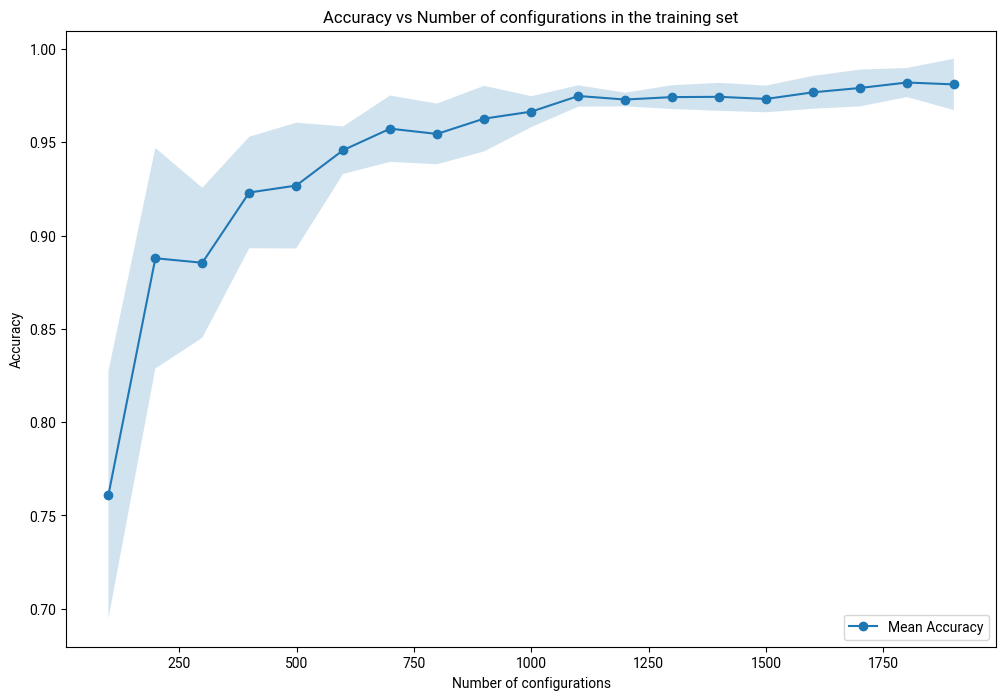

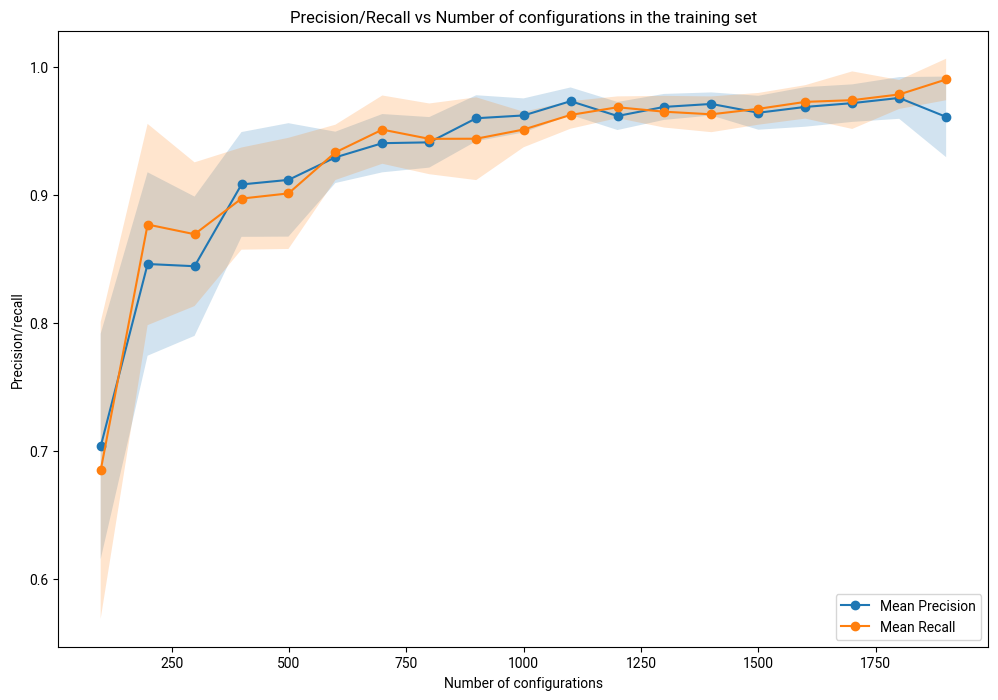

In [72]:
mk_evolution(rq2v6139df)

# RQ3 - Can we prevent non-reproducible builds?

# RQ4 - Transferability in time and space

# RQ5 - Manual check and explaination